# **Funnel Analysis for Cosmetics Datasets**

This project analyzes user behavior data from a cosmetics e-commerce platform to understand the purchase process and identify key opportunities for increasing sales, utilizing funnel analysis as the primary method. Funnel analysis allows for a detailed breakdown of the purchasing process—tracking how users progress from product browsing to adding items to their cart and finally making a purchase—while quantifying the drop-off rates at each stage. By identifying where the most significant drop-offs occur, the analysis highlights the main obstacles to higher conversion rates and suggests practical strategies for improvement.

Insights derived from this process are intended to support sales growth, increase customer engagement, and ultimately boost the overall conversion rate for the platform.

#### **Data Description**

- event_time: The time when the event occurred (in UTC)

- event_type: Type of event (e.g., purchase)

- product_id: Product ID

- category_id: Category ID of the product

- category_code: Product category code (present if the category has a meaningful label)

- brand: Brand name (lowercase, may be omitted)

- price: Price of the product

- user_id: User ID

- user_session: User session ID (temporary, changes with each session)

## **I. Data Loading**

In [1]:
import numpy as np
import pandas as pd

!apt-get -qq install fonts-nanum
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

plt.rc('font', family='NanumGothic')
plt.rc('font', family='AppleGothic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install plotly
!pip install plotly --upgrade

In [3]:
!pip install --upgrade kaleido

In [4]:
!plotly_get_chrome


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: /usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe
Do you want to proceed? [y/n] y
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


In [5]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
from IPython.core.interactiveshell import InteractiveShell
from plotly.offline import iplot
cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl', offline=True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/DataAnalytics/cosmetic.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


## **II. Data Preprocessing**

In [8]:
df.shape

(3533286, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533286 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 242.6+ MB


In [10]:
df['event_time'] = pd.to_datetime(df['event_time'])
df['event_time']

,event_time
0,2019-12-01 00:00:00+00:00
1,2019-12-01 00:00:00+00:00
2,2019-12-01 00:00:02+00:00
3,2019-12-01 00:00:05+00:00
4,2019-12-01 00:00:07+00:00
...,...
3533281,2019-12-31 23:59:39+00:00
3533282,2019-12-31 23:59:46+00:00
3533283,2019-12-31 23:59:51+00:00
3533284,2019-12-31 23:59:52+00:00


In [11]:
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,3474821
brand,1510289
price,0
user_id,0
user_session,779


With almost 98% of its values missing, the category_code column will be dropped from the dataset.

In [12]:
df = df.drop('category_code', axis=1)
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
brand,1510289
price,0
user_id,0
user_session,779


Missing brand values will be filled using the product_id, since products with the same ID share the same brand.

In [13]:
df.query('product_id == 5916983')

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
3374835,2019-12-29 07:11:47+00:00,view,5916983,1783999073758478650,NaN,0.00,410144142,57484fc7-f6a4-45ba-b95a-9116ead6d96f
3397074,2019-12-29 13:00:50+00:00,cart,5916983,1783999073758478650,NaN,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397086,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,NaN,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397087,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,NaN,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397111,2019-12-29 13:01:02+00:00,view,5916983,1783999073758478650,NaN,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3468885,2019-12-30 12:36:57+00:00,cart,5916983,1783999073758478650,beautific,27.52,592007896,84475418-083b-4a8e-ab7f-8d38994b1f12
3470599,2019-12-30 12:59:20+00:00,view,5916983,1783999073758478650,beautific,27.52,477270774,e5670c53-8674-4725-86e2-dc6bfd39c04c
3498570,2019-12-30 21:43:54+00:00,view,5916983,1783999073758478650,beautific,27.52,583884978,d6f873d5-7935-454c-9849-9fbf1b05fd53


In [14]:
# Fill missing brand info within each product (forward & backward)
df['brand'] = df.groupby('product_id')['brand'].transform(lambda x: x.ffill().bfill())

In [15]:
df.query('product_id == 5916983')

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
3374835,2019-12-29 07:11:47+00:00,view,5916983,1783999073758478650,beautific,0.00,410144142,57484fc7-f6a4-45ba-b95a-9116ead6d96f
3397074,2019-12-29 13:00:50+00:00,cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397086,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397087,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397111,2019-12-29 13:01:02+00:00,view,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3468885,2019-12-30 12:36:57+00:00,cart,5916983,1783999073758478650,beautific,27.52,592007896,84475418-083b-4a8e-ab7f-8d38994b1f12
3470599,2019-12-30 12:59:20+00:00,view,5916983,1783999073758478650,beautific,27.52,477270774,e5670c53-8674-4725-86e2-dc6bfd39c04c
3498570,2019-12-30 21:43:54+00:00,view,5916983,1783999073758478650,beautific,27.52,583884978,d6f873d5-7935-454c-9849-9fbf1b05fd53


In [16]:
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
brand,1503141
price,0
user_id,0
user_session,779


In [17]:
df[['brand', 'user_session']] = df[['brand', 'user_session']].fillna('N/A')
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
brand,0
price,0
user_id,0
user_session,0


In [18]:
df.describe().applymap(lambda n: '{:.2f}'.format(n))

,product_id,category_id,price,user_id
count,3533286.00,3533286.00,3533286.00,3533286.00
mean,5473053.80,1555023012945680128.00,8.87,522331835.07
std,1331331.39,168926187070693152.00,19.86,84948189.60
min,3752.00,1487580004807082752.00,-79.37,1180452.00
25%,5726191.00,1487580006300255232.00,2.06,486682994.00
50%,5811429.00,1487580008447738880.00,4.21,556649586.00
75%,5859462.00,1487580013581566208.00,7.14,582801855.00
max,5917178.00,2235524499636224256.00,327.78,595414541.00


In [19]:
# Count rows where price < 0
len(df.query('price < 0'))

18

In [20]:
df.query('price < 0').product_id.unique()

array([5670257, 5716859, 5716857, 5716855, 5716861])

In [21]:
df = df.query('price >= 0')

In [22]:
len(df.query('price == 0'))

7589

In [23]:
# Unique product_ids with price 0
df.query('price == 0').product_id.nunique()

2156

In [24]:
df.query('product_id == 5916983')

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
3374835,2019-12-29 07:11:47+00:00,view,5916983,1783999073758478650,beautific,0.00,410144142,57484fc7-f6a4-45ba-b95a-9116ead6d96f
3397074,2019-12-29 13:00:50+00:00,cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397086,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397087,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397111,2019-12-29 13:01:02+00:00,view,5916983,1783999073758478650,beautific,0.00,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3468885,2019-12-30 12:36:57+00:00,cart,5916983,1783999073758478650,beautific,27.52,592007896,84475418-083b-4a8e-ab7f-8d38994b1f12
3470599,2019-12-30 12:59:20+00:00,view,5916983,1783999073758478650,beautific,27.52,477270774,e5670c53-8674-4725-86e2-dc6bfd39c04c
3498570,2019-12-30 21:43:54+00:00,view,5916983,1783999073758478650,beautific,27.52,583884978,d6f873d5-7935-454c-9849-9fbf1b05fd53


In [25]:
# Replace price 0 with mean of that product (excluding 0)
df['price'] = df.groupby('product_id')['price'].transform(lambda y: y.replace(0, y[y!=0].mean()))

In [26]:
df.query('product_id == 5916983')

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
3374835,2019-12-29 07:11:47+00:00,view,5916983,1783999073758478650,beautific,27.52,410144142,57484fc7-f6a4-45ba-b95a-9116ead6d96f
3397074,2019-12-29 13:00:50+00:00,cart,5916983,1783999073758478650,beautific,27.52,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397086,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,27.52,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397087,2019-12-29 13:00:55+00:00,remove_from_cart,5916983,1783999073758478650,beautific,27.52,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3397111,2019-12-29 13:01:02+00:00,view,5916983,1783999073758478650,beautific,27.52,355374962,de91420a-9375-4477-b44f-c072e1604f2c
3468885,2019-12-30 12:36:57+00:00,cart,5916983,1783999073758478650,beautific,27.52,592007896,84475418-083b-4a8e-ab7f-8d38994b1f12
3470599,2019-12-30 12:59:20+00:00,view,5916983,1783999073758478650,beautific,27.52,477270774,e5670c53-8674-4725-86e2-dc6bfd39c04c
3498570,2019-12-30 21:43:54+00:00,view,5916983,1783999073758478650,beautific,27.52,583884978,d6f873d5-7935-454c-9849-9fbf1b05fd53


In [27]:
len(df.query('price==0'))

0

In [28]:
df.duplicated().sum()

np.int64(183859)

In [29]:
df = df.drop_duplicates()

In [30]:
df.duplicated().sum()

np.int64(0)

In [31]:
df.shape

(3349409, 8)

## **III. Data Analysis**

### **3-1. Funnel Analysis**

**Preparing Data for Funnel Analysis**

In [32]:
df['event_type'].value_counts()

,count
event_type,
view,1728221
cart,911641
remove_from_cart,496498
purchase,213049


The data includes user actions such as view, cart, remove_from_cart, and purchase, but some funnels may not start with a view event due to the limited date range. To prevent this from distorting the funnel analysis, only user_id and product_id pairs whose first event is a view are included.

In [33]:
df.query('product_id == 5629988 & user_id == 579966747')

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
6,2019-12-01 00:00:18+00:00,cart,5629988,1487580009311764506,N/A,1.19,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b
478708,2019-12-04 14:37:33+00:00,purchase,5629988,1487580009311764506,N/A,1.19,579966747,4f7bd471-2dca-4fbf-8a7a-8fae2d0feae8


In [34]:
df.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,N/A,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [35]:
# Sort by user/product/time
df = df.sort_values(['user_id', 'product_id', 'event_time'])

# Get first event per user/product combo
first_evt = df.groupby(['user_id', 'product_id']).first()

# Only those combos where first event is 'view'
idx_keep = first_evt.query('event_type == "view"').index

# Keep only those rows in main df
df = df.set_index(['user_id', 'product_id']).loc[idx_keep].reset_index()

In [36]:
# Check that the filtering worked
df.query('product_id == 5629988 & user_id == 579966747')

,user_id,product_id,event_time,event_type,category_id,brand,price,user_session


**Measuring Drop-off Rates by User Count at Each Funnel Stage**

Funnel analysis can be done using two approaches: by event count or by unique users. With event-based calculation, if a user views Product A twice and adds it to the cart once, the conversion rate is 50%. In contrast, when using unique users, that same scenario would count as a 100% conversion, since the user progressed from view to cart at least once.

In this analysis, I will use the latter approach—calculating by unique user count.

In [37]:
df.head()

,user_id,product_id,event_time,event_type,category_id,brand,price,user_session
0,1180452,5881337,2019-12-28 14:32:56+00:00,view,1487580012096782476,fedua,25.40,a4818e6d-9069-4aa8-8731-572ac266283f
1,2963072,5656122,2019-12-22 13:04:49+00:00,view,1487580009026551821,N/A,23.57,3bf2bbbb-1a32-4f06-a263-a3f49db74750
2,2963072,5700025,2019-12-22 13:09:11+00:00,view,1487580010100293687,runail,1.90,3bf2bbbb-1a32-4f06-a263-a3f49db74750
3,2963072,5707747,2019-12-22 12:50:45+00:00,view,1487580009051717646,N/A,73.02,3bf2bbbb-1a32-4f06-a263-a3f49db74750
4,2963072,5707747,2019-12-22 12:53:12+00:00,view,1487580009051717646,N/A,73.02,3bf2bbbb-1a32-4f06-a263-a3f49db74750


In [38]:
# Count unique users per event type & product
user_cnt = df.groupby(['event_type', 'product_id'])['user_id'].nunique()
user_cnt = user_cnt.groupby('event_type').sum().reset_index()

# Rename for clarity
user_cnt = user_cnt.rename(columns={'user_id': 'users'})
user_cnt = user_cnt[user_cnt['event_type'] != 'remove_from_cart']

# Sort by user count
user_cnt = user_cnt.sort_values('users', ascending=False)
user_cnt

,event_type,users
3,view,1168441
0,cart,145921
1,purchase,53250


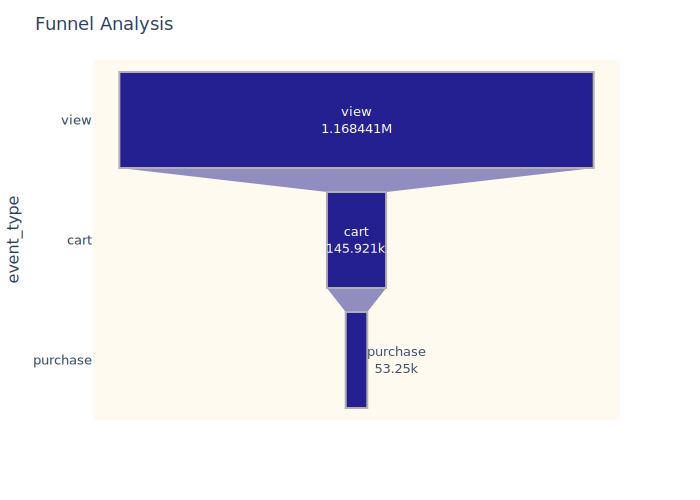

In [39]:
import plotly.express as px

fig = px.funnel(user_cnt, x='users', y='event_type', color_discrete_sequence=px.colors.sequential.Plasma)
fig.update_traces(marker_line_color='darkgray', marker_line_width=2, textinfo='label+value', opacity=0.9)
fig.update_layout(plot_bgcolor='#fffaf0', title='Funnel Analysis', font=dict(size=13))
fig.show(renderer="svg")

In [40]:
# Conversion %
user_cnt['conversion_rate(%)'] = user_cnt['users'] / user_cnt['users'].shift(1)*100

# Churn %
user_cnt['churn_rate(%)'] = 100 - user_cnt['conversion_rate(%)']
user_cnt

,event_type,users,conversion_rate(%),churn_rate(%)
3,view,1168441,NaN,NaN
0,cart,145921,12.488521,87.511479
1,purchase,53250,36.492349,63.507651


About 88% drop off between the view and cart steps, and roughly 64% drop off between the cart and purchase stages.

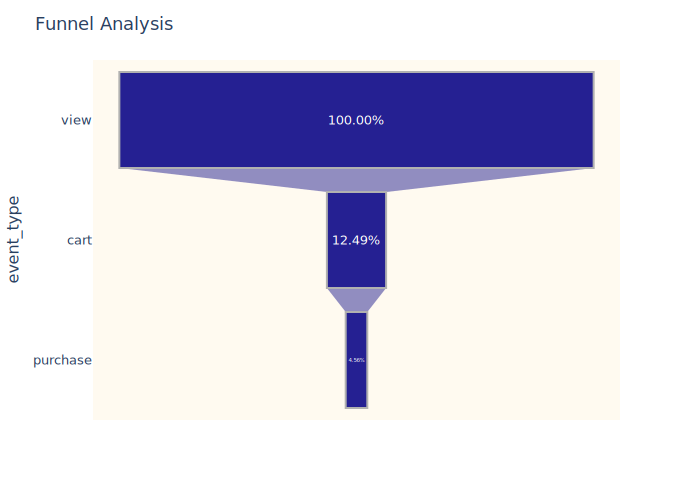

In [41]:
# Relative conversion rate (vs. total 'view' users)
user_cnt['conversion_rate_total'] = user_cnt['users'] / user_cnt.iloc[0, 1]

# Funnel chart of total conversion
fig = px.funnel(user_cnt, x='conversion_rate_total', y='event_type', hover_data={'conversion_rate_total': ':.2%'},
                color_discrete_sequence=px.colors.sequential.Plasma)
fig.update_traces(marker_line_color='darkgray', marker_line_width=2,
                  textinfo='label+value', opacity=0.9, texttemplate="%{value:.2%}")
fig.update_layout(plot_bgcolor='#fffaf0', title='Funnel Analysis', font=dict(size=13))
fig.show(renderer="svg")

In summary, about 12% of users who viewed a product added it to their cart, and only around 5% of product views resulted in a purchase.

### **3-2. Analyzing Causes of Drop-off**

**(1) Analysis by Price Range**

In [42]:
temp = df[['product_id', 'price']].drop_duplicates()
temp['price'].quantile([.25, .5, .75])

,price
0.25,2.78
0.50,4.86
0.75,8.41


In [43]:
def to_price_bin(p):
    if p <= 3: return '~3'
    elif p <= 5: return '3~5'
    elif p <= 8: return '5~8'
    return '8~'

df['price_range'] = df['price'].apply(to_price_bin)
df[['price', 'price_range']].head()

,price,price_range
0,25.40,8~
1,23.57,8~
2,1.90,~3
3,73.02,8~
4,73.02,8~


In [44]:
# Unique user count by price group, event, product
price_funnel = df.groupby(['price_range', 'event_type', 'product_id'])['user_id'].nunique()
price_funnel = price_funnel.groupby(['price_range', 'event_type']).sum().reset_index()

# Rename
price_funnel = price_funnel.rename(columns={'user_id': 'users'})
price_funnel = price_funnel[price_funnel['event_type'] != 'remove_from_cart']

# Order steps in each price group
price_funnel = price_funnel.groupby('price_range').apply(
    lambda z: z.sort_values('users', ascending=False)).reset_index(drop=True)
price_funnel

,price_range,event_type,users
0,3~5,view,237058
1,3~5,cart,33321
2,3~5,purchase,11685
3,5~8,view,238430
4,5~8,cart,31101
5,5~8,purchase,10586
6,8~,view,376831
7,8~,cart,31728
8,8~,purchase,11138
9,~3,view,316323


In [45]:
# Conversion per price group
price_funnel['conversion_rate'] = price_funnel['users'] / price_funnel.groupby('price_range')['users'].transform('first')
price_funnel

,price_range,event_type,users,conversion_rate
0,3~5,view,237058,1.000000
1,3~5,cart,33321,0.140561
2,3~5,purchase,11685,0.049292
3,5~8,view,238430,1.000000
4,5~8,cart,31101,0.130441
5,5~8,purchase,10586,0.044399
6,8~,view,376831,1.000000
7,8~,cart,31728,0.084197
8,8~,purchase,11138,0.029557
9,~3,view,316323,1.000000


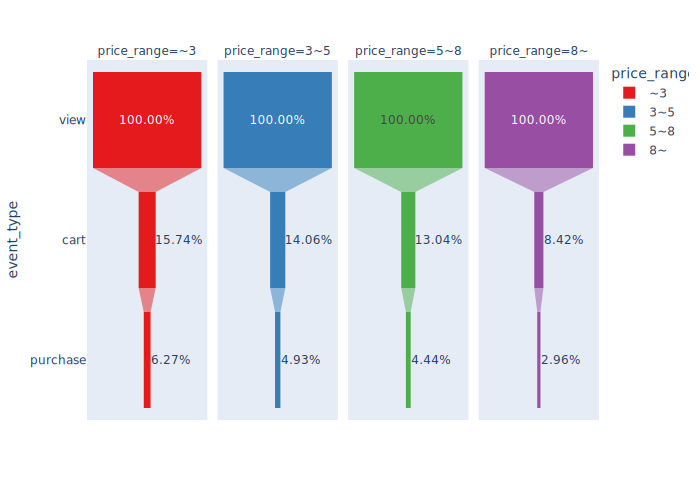

In [46]:
fig = px.funnel(
    price_funnel, x='conversion_rate', y='event_type', color='price_range', facet_col='price_range',
    category_orders={'price_range': ['~3', '3~5', '5~8', '8~']},
    color_discrete_sequence=px.colors.qualitative.Set1,
    hover_data={'conversion_rate': ':.2%'}
)
fig.update_traces(texttemplate="%{value:.2%}")
fig.show(renderer="svg")

It’s clear that higher-priced products have lower conversion rates to purchase.

In [47]:
pvt = price_funnel.pivot(index='price_range', columns='event_type', values='users')

# Calculate view-to-cart and cart-to-purchase conversion rates
pvt['view_to_cart'] = pvt['cart'] / pvt['view']*100
pvt['cart_to_purchase'] = pvt['purchase'] / pvt['cart']*100

pvt = pvt[['view', 'cart', 'purchase', 'view_to_cart', 'cart_to_purchase']]
pvt.reindex(index=['~3', '3~5', '5~8', '8~'])

event_type,view,cart,purchase,view_to_cart,cart_to_purchase
price_range,,,,,
~3,316323,49778,19841,15.736447,39.858974
3~5,237058,33321,11685,14.056054,35.067975
5~8,238430,31101,10586,13.044080,34.037491
8~,376831,31728,11138,8.419689,35.104639


As product price increases, the view-to-cart conversion rate drops sharply, while the cart-to-purchase rate only differs significantly between products priced at 3 or less and those above that threshold. For higher price ranges, the cart-to-purchase rate remains relatively steady.

Therefore, for higher-priced products, it’s important to focus on boosting the view-to-cart rate—perhaps by highlighting discounts or special offers. For products priced at 3 or less, since users are more likely to purchase after they’ve added items to their cart, sending reminders about items left in the cart could help encourage more purchases.

**(2) Brand Analysis**

In [48]:
# Exclude rows with missing brand info
df_b = df.query('brand != "N/A"')

# Count unique users per brand, event type, and product
brand_funnel = df_b.groupby(['brand', 'event_type', 'product_id'])['user_id'].nunique()
brand_funnel_df = brand_funnel.reset_index(name='user_id')

# Convert to pivot table
brand_pvt = pd.pivot_table(
    data=brand_funnel_df, index='brand', columns='event_type', values='user_id', aggfunc='sum')

# Select only the relevant funnel steps
brand_pvt = brand_pvt[['view', 'cart', 'purchase']]

# Calculate conversion rates for each step
brand_pvt['view_to_cart'] = brand_pvt['cart'] / brand_pvt['view']*100
brand_pvt['cart_to_purchase'] = brand_pvt['purchase'] / brand_pvt['cart']*100
brand_pvt['view_to_purchase'] = brand_pvt['purchase'] / brand_pvt['view']*100

brand_pvt.head()

event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
brand,,,,,,
airnails,3552.0,429.0,190.0,12.077703,44.289044,5.349099
almea,475.0,43.0,20.0,9.052632,46.511628,4.210526
andrea,61.0,5.0,1.0,8.196721,20.000000,1.639344
ardell,2508.0,241.0,75.0,9.609250,31.120332,2.990431
art-visage,3471.0,604.0,210.0,17.401325,34.768212,6.050130


In [49]:
# Top brands by view count
brand_pvt.sort_values('view', ascending=False).head(10)

event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
brand,,,,,,
runail,72951.0,10803.0,4065.0,14.808570,37.628437,5.572233
grattol,50377.0,6947.0,2221.0,13.790023,31.970635,4.408758
irisk,46254.0,5860.0,2246.0,12.669175,38.327645,4.855796
estel,32444.0,3679.0,1343.0,11.339539,36.504485,4.139440
masura,31837.0,4103.0,1401.0,12.887521,34.145747,4.400540
kapous,31701.0,2569.0,886.0,8.103845,34.488128,2.794865
jessnail,24051.0,1609.0,492.0,6.689951,30.577999,2.045653
bpw.style,22161.0,3558.0,1622.0,16.055232,45.587409,7.319164
ingarden,18808.0,2763.0,979.0,14.690557,35.432501,5.205232


In [50]:
# Brands with highest view-to-purchase (only if view >= 100)
brand_pvt[brand_pvt['view'] >= 100].sort_values('view_to_purchase', ascending=False).head(10)

event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
brand,,,,,,
elskin,250.0,70.0,37.0,28.000000,52.857143,14.800000
balbcare,515.0,106.0,51.0,20.582524,48.113208,9.902913
inm,249.0,38.0,22.0,15.261044,57.894737,8.835341
gehwol,493.0,77.0,41.0,15.618661,53.246753,8.316430
benovy,915.0,154.0,76.0,16.830601,49.350649,8.306011
tannymaxx,161.0,28.0,13.0,17.391304,46.428571,8.074534
severina,3212.0,556.0,258.0,17.310087,46.402878,8.032379
estelare,595.0,115.0,46.0,19.327731,40.000000,7.731092
skinlite,881.0,175.0,68.0,19.863791,38.857143,7.718502


In [51]:
# Brands with lowest view-to-purchase (only if view >= 100)
brand_pvt[brand_pvt['view'] >= 100].sort_values('view_to_purchase').head(10)

event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
brand,,,,,,
kosmekka,2521.0,29.0,4.0,1.150337,13.793103,0.158667
s.care,461.0,7.0,1.0,1.518438,14.285714,0.216920
kims,668.0,9.0,3.0,1.347305,33.333333,0.449102
babyliss,931.0,32.0,5.0,3.437164,15.625000,0.537057
enjoy,130.0,5.0,1.0,3.846154,20.000000,0.769231
greymy,128.0,8.0,1.0,6.250000,12.500000,0.781250
tertio,499.0,18.0,4.0,3.607214,22.222222,0.801603
beautyblender,122.0,6.0,1.0,4.918033,16.666667,0.819672
egomania,105.0,7.0,1.0,6.666667,14.285714,0.952381


Kosmekka is analyzed because it has a notably low purchase conversion rate and a significant gap between product views and purchases.

**Price Comparison**

In [52]:
# Collect non-duplicate brand/product/price info
product_df = df[['brand', 'product_id', 'price']].drop_duplicates()

# Mean price overall
print('Mean price overall:', product_df['price'].mean())

# Mean price by brand (esp. kosmekka vs. elskin)
product_df[product_df['brand'].isin(['kosmekka', 'elskin'])].groupby('brand')['price'].mean()

Mean price overall: 8.029075581045227


,price
brand,
elskin,1.653571
kosmekka,59.245000


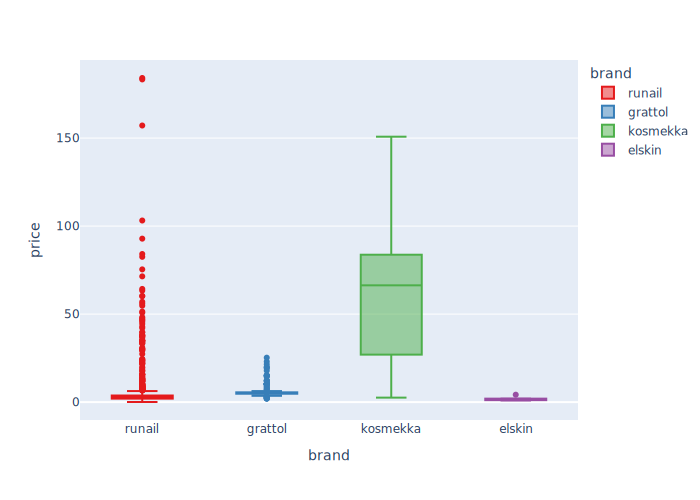

In [53]:
fig = px.box(product_df.query('brand in ["kosmekka", "elskin", "runail", "grattol"]'), x='brand', y='price', color='brand', color_discrete_sequence=px.colors.qualitative.Set1)
fig.show(renderer="svg")

Kosmekka’s high prices likely contribute to its low conversion rates, as customers on this platform are price sensitive.

**Time-of-Day Analysis**

In [54]:
# Extract event hour
df['event_hour'] = df['event_time'].dt.hour
df[['event_time', 'event_hour']].head()

,event_time,event_hour
0,2019-12-28 14:32:56+00:00,14
1,2019-12-22 13:04:49+00:00,13
2,2019-12-22 13:09:11+00:00,13
3,2019-12-22 12:50:45+00:00,12
4,2019-12-22 12:53:12+00:00,12


In [55]:
# Unique user count by hour/event/product
hourly_funnel = df.groupby(['event_hour', 'event_type', 'product_id'])['user_id'].nunique()
hourly_funnel_df = hourly_funnel.reset_index(name='user_id')
hourly_pvt = pd.pivot_table(
    data=hourly_funnel_df, index='event_hour', columns='event_type', values='user_id', aggfunc='sum'
)

# Keep funnel steps and order
hourly_pvt = hourly_pvt[['view', 'cart', 'purchase']]

# Calc conversion by hour
hourly_pvt['view_to_purchase'] = hourly_pvt['purchase'] / hourly_pvt['view'] * 100
hourly_pvt['view_to_cart'] = hourly_pvt['cart'] / hourly_pvt['view'] * 100
hourly_pvt['cart_to_purchase'] = hourly_pvt['purchase'] / hourly_pvt['cart'] * 100

hourly_pvt.head()

event_type,view,cart,purchase,view_to_purchase,view_to_cart,cart_to_purchase
event_hour,,,,,,
0,13875,1455,460,3.315315,10.486486,31.615120
1,11360,1251,408,3.591549,11.012324,32.613909
2,12126,1318,353,2.911100,10.869207,26.783005
3,17018,1797,485,2.849924,10.559408,26.989427
4,25739,2739,739,2.871129,10.641439,26.980650


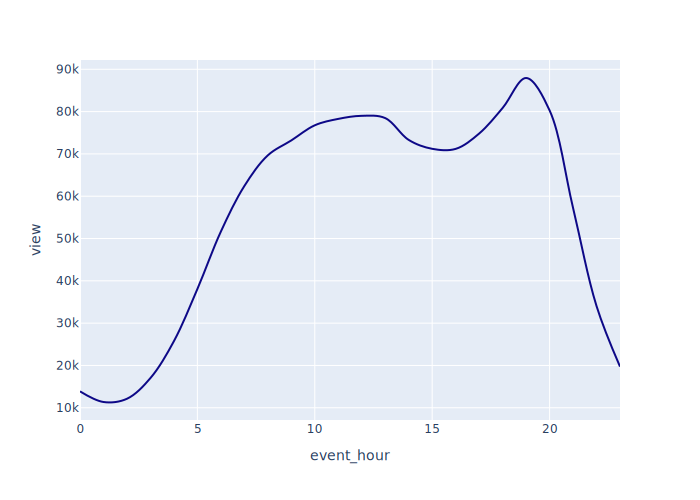

In [56]:
# Hourly trends - number of views
fig = px.line(hourly_pvt.reset_index(), x='event_hour', y='view', line_shape='spline', color_discrete_sequence=px.colors.sequential.Plasma)
fig.show(renderer="svg")

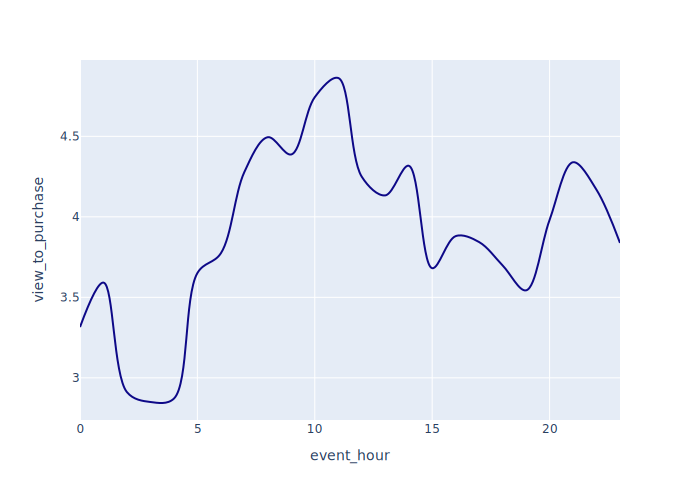

In [57]:
# Hourly trends - view to purchase conversion
fig = px.line(hourly_pvt.reset_index(), x='event_hour', y='view_to_purchase', line_shape='spline', color_discrete_sequence=px.colors.sequential.Plasma)
fig.show(renderer="svg")

In [58]:
# kosmekka
df_k = df[df['brand'] == 'kosmekka']

# Funnel for kosmekka
kos_funnel = df_k.groupby(['event_hour', 'event_type', 'product_id'])['user_id'].nunique()
kos_funnel_df = kos_funnel.reset_index(name='user_id')
kos_pvt = pd.pivot_table(
    data=kos_funnel_df, index='event_hour', columns='event_type', values='user_id', aggfunc='sum', fill_value=0)
kos_pvt = kos_pvt[['view', 'cart', 'purchase']]

kos_pvt['view_to_purchase'] = kos_pvt['purchase'] / kos_pvt['view'] * 100
kos_pvt['view_to_cart'] = kos_pvt['cart'] / kos_pvt['view'] * 100
kos_pvt['cart_to_purchase'] = kos_pvt['purchase'] / kos_pvt['cart'] * 100

kos_pvt.head()

event_type,view,cart,purchase,view_to_purchase,view_to_cart,cart_to_purchase
event_hour,,,,,,
0,30,0,0,0.0,0.0,NaN
1,22,0,0,0.0,0.0,NaN
2,34,0,0,0.0,0.0,NaN
3,42,0,0,0.0,0.0,NaN
4,56,0,0,0.0,0.0,NaN


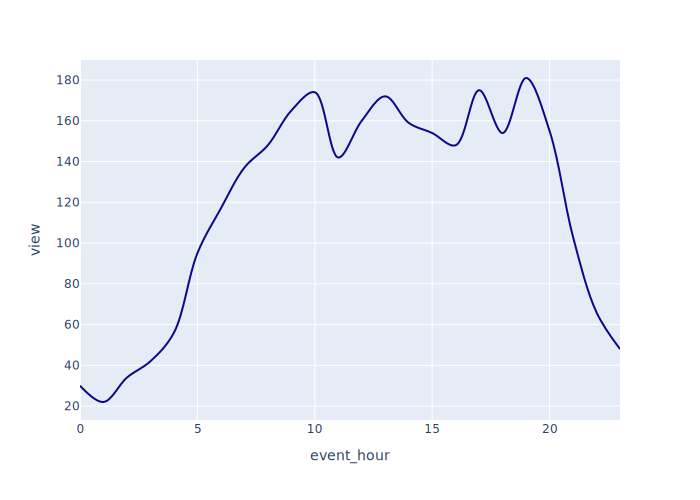

In [59]:
# View trend for kosmekka
fig = px.line(kos_pvt.reset_index(), x='event_hour', y='view', line_shape='spline', color_discrete_sequence=px.colors.sequential.Plasma)
fig.show(renderer="svg")

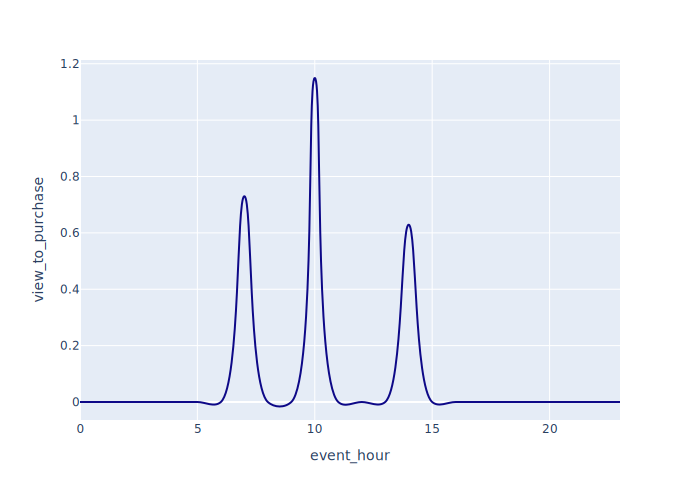

In [60]:
# view to purchase conversion for kosmekka
fig = px.line(kos_pvt.reset_index(), x='event_hour', y='view_to_purchase', line_shape='spline', color_discrete_sequence=px.colors.sequential.Plasma)
fig.show(renderer="svg")

Since user activity peaks in the evening, the platform could prioritize brands with higher purchase conversion rates during these hours instead of promoting low-performing brands like kosmekka.

## **IV. Conclusion**

### **1. Key Findings**

Analysis of the funnel data reveals that, on average, 12% of users who view a product add it to their cart, and about 5% complete a purchase. The view-to-cart conversion rate drops noticeably as product prices increase—from approximately 15% for products priced at 3 or less, down to 8% for those above 8. In contrast, the cart-to-purchase conversion rate is close to 40% for products priced at 3 or less, while it remains steady at around 35% for other price categories. This indicates that, although the rate is slightly higher for lower-priced items, the overall likelihood of completing a purchase after adding an item to the cart is relatively high and stable, regardless of product price. These findings suggest that the main bottleneck lies in encouraging users to add items to their carts—particularly for higher-priced products. User browsing activity peaks around 7 PM, while purchases are most frequently completed at 11 AM, highlighting a temporal gap between product exploration and transaction completion.

### **2. Strategic Recommendations**

Based on these findings, the platform should prioritize increasing the rate at which users add high-priced items to their carts by leveraging targeted promotions, discounts, or enhanced product visibility. For products priced at 3 or less, where the cart-to-purchase rate is slightly higher, automated reminders about inactive carts can help drive additional purchases.

Kosmekka was selected for separate analysis because it attracts a high number of product views but its purchase conversion rate is exceptionally low. The analysis suggests that high prices are a key reason for this low conversion. For brands that receive significant interest but have low sales as a result of high prices, alternative strategies such as creating a dedicated premium section or reallocating exposure to brands that better match user price sensitivity should be considered.

In conclusion, directing resources toward motivating users to add items to their carts is expected to have the most significant impact on improving overall sales performance for the platform.